In [1]:
from keras.datasets import mnist

from matplotlib import pyplot as plt
import numpy as np

import sklearn.preprocessing
import sklearn.metrics
from sklearn.metrics import ConfusionMatrixDisplay

from tqdm import tqdm

np.set_printoptions(formatter={"float": lambda x: "{0:0.3f}".format(x)})

2024-12-12 02:06:39.719113: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733958399.740523  721235 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733958399.746682  721235 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-12 02:06:39.768479: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# ВТ_Торч.nn
# На numpy, только для процессора

In [2]:
from nn.nn import NN
from nn.layers import Conv2DLayer, MaxPoolingLayer, LinearLayer, DropoutLayer, FlattenLayer
from nn.optimizers import AdamOptimizer
from nn.functional import Relu, Softmax, cross_entropy
from nn.verify import verify

Стандартная предобработка для mnist

In [3]:
(train_x, train_y), (test_x, test_y) = mnist.load_data()

train_x = train_x / 255
test_x = test_x / 255

train_x.resize(60000, 784)
test_x.resize(10000, 784)

encoder = sklearn.preprocessing.OneHotEncoder()
train_y = encoder.fit_transform(train_y[..., None]).toarray()
test_y = encoder.fit_transform(test_y[..., None]).toarray()

train_x.shape, train_y.shape

((60000, 784), (60000, 10))

In [52]:
# model = NN(
#     [
#         MaxPoolingLayer(kernel=(2, 2), strides=(2, 2)),
#         Conv2DLayer(1, 32, kernel=(3, 3), strides=(1, 1), padding=(1, 1)),
#         Relu(),
#         MaxPoolingLayer(kernel=(2, 2), strides=(2, 2)),
#         Conv2DLayer(32, 16, kernel=(3, 3), strides=(1, 1), padding=(1, 1)),
#         Relu(),
#         FlattenLayer(),
#         LinearLayer(16 * 7 * 7, 64),
#         Relu(),
#         DropoutLayer(0.2),
#         LinearLayer(64, 10),
#         Softmax()
#     ],
#     loss_function=cross_entropy,
# )

model = NN(
    [
        Conv2DLayer(1, 8, kernel=(5, 5), strides=(1, 1), padding=(0, 0)),
        Relu(),
        MaxPoolingLayer(kernel=(2, 2), strides=(2, 2)),
        Conv2DLayer(8, 8, kernel=(3, 3), strides=(1, 1), padding=(0, 0)),
        Relu(),
        MaxPoolingLayer(kernel=(2, 2), strides=(2, 2)),
        FlattenLayer(),
        LinearLayer(200, 10),
        Softmax()
    ],
    loss_function=cross_entropy,
)

loss_history = []

In [53]:
def initialize_weights(node):
    node.weights = np.random.rand(*node.weights.shape) * 0.1
    node.bias = np.random.rand(*node.bias.shape) * 0.1
    
model.initialize_weights(initialize_weights)

In [54]:
verify(model, np.random.random((1, 28, 28)), np.random.random((1, 10)))

+-------+-----------------+-------------+-------------+--------------------------+-----------------+-----------------+
| Номер |      Слой       |    Вход     |    Выход    |        Параметры         |     forward     |    backward     |
+-------+-----------------+-------------+-------------+--------------------------+-----------------+-----------------+
|   1   |   Conv2DLayer   | (1, 28, 28) | (8, 24, 24) | 208 (8, 1, 5, 5) + (8,)  | 0.001109 (52 %) | 0.000001 (0 %)  |
|   2   |      Relu       | (8, 24, 24) | (8, 24, 24) |                          | 0.000039 (1 %)  | 0.000038 (1 %)  |
|   3   | MaxPoolingLayer | (8, 24, 24) | (8, 12, 12) |                          | 0.000355 (16 %) | 0.000004 (0 %)  |
|   4   |   Conv2DLayer   | (8, 12, 12) | (8, 10, 10) | 584 (8, 8, 3, 3) + (8,)  | 0.000343 (16 %) | 0.000306 (8 %)  |
|   5   |      Relu       | (8, 10, 10) | (8, 10, 10) |                          | 0.000021 (0 %)  | 0.000020 (0 %)  |
|   6   | MaxPoolingLayer | (8, 10, 10) |  (8, 5

Прогоним 50к картинок

In [55]:
def train(
    network: NN, x, y, num_epoches: int, batch_size: int,
    optimizer, loss_history: list, sub_samples: int = 1000):
    bar = tqdm(range(1, num_epoches + 1), total=num_epoches)
    xy_indices = np.arange(len(x))
    
    for epoch in bar:
        
        optimizer.zero_grad()
        network.predicted.clear()
        # В каждой эпохе изменим порядок обучающего датасета
        np.random.shuffle(xy_indices)

        indices = np.random.choice(len(xy_indices), size=sub_samples, replace=False)

        epoch_x = x[indices]
        epoch_y = y[indices]
        
        network.train(
            epoch_x,
            epoch_y,
            optimizer,
            batch_size=batch_size,
        )
        
        # Средний loss за эпоху
        loss = network.pop_loss(np.mean)
        loss_history.append(loss)

        bar.set_description(
            f"epoch: {epoch}, loss: {loss:.10f}"
        )
        network.losses.clear()
    return loss_history

optimizer = AdamOptimizer(model.get_learnables(), 0.4, 0.999, 0.0003)

loss_history = train(
    model, train_x.reshape((60000, 1, 28, 28)), train_y, 100, 25, optimizer, loss_history
)

epoch: 100, loss: 2.5175565915: 100%|██████████| 100/100 [02:43<00:00,  1.64s/it]


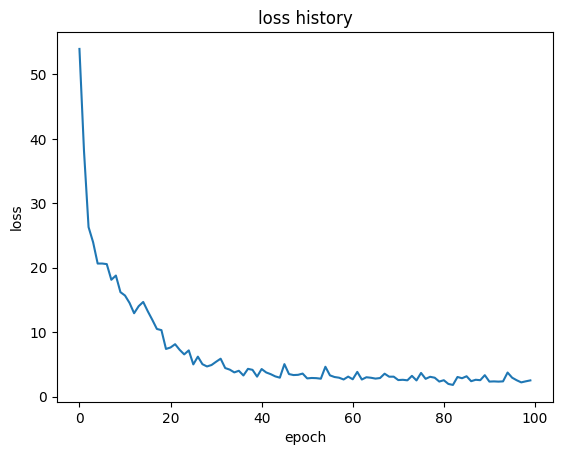

In [56]:
fig, ax = plt.subplots()

ax.plot(loss_history)
ax.set_xlabel("epoch")
ax.set_ylabel("loss")
ax.set_title("loss history")
plt.show()

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.97      0.98      0.98      1032
           3       0.94      0.99      0.97      1010
           4       0.99      0.98      0.98       982
           5       0.98      0.97      0.98       892
           6       0.99      0.98      0.98       958
           7       0.98      0.96      0.97      1028
           8       0.97      0.96      0.97       974
           9       0.96      0.96      0.96      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



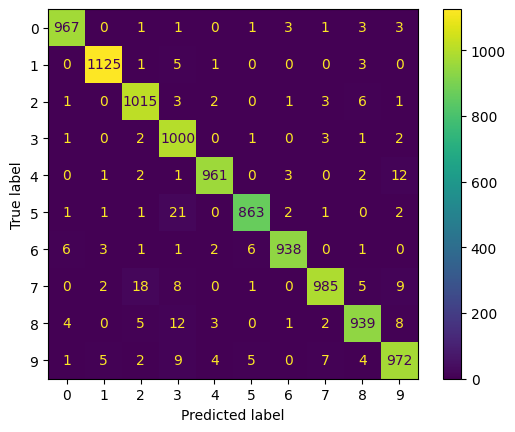

In [57]:
y_pred = []
for i in range(len(test_x)):
    y_pred.append(model.forward(test_x[i].reshape((1, 28, 28)))[0])

y_pred_classes = [x for x in np.argmax(y_pred, axis=1)]
y_true_classes = [x for x in np.argmax(test_y, axis=1)]

print(sklearn.metrics.classification_report(y_true_classes, y_pred_classes))
ConfusionMatrixDisplay.from_predictions(y_true_classes, y_pred_classes)

Неплохо, посмотрим, насколько интерпретируемы фильтры

In [58]:
def show_multiple(images, rows, columns):
    _, axes = plt.subplots(rows, columns, figsize=(1.5 * columns, 2 * rows))
    for i in range(images.shape[0]):
        if rows == 1:
            ax = axes[i]
        else:
            ax = axes[i // columns, i % columns]
        ax.imshow(images[i], cmap='gray')

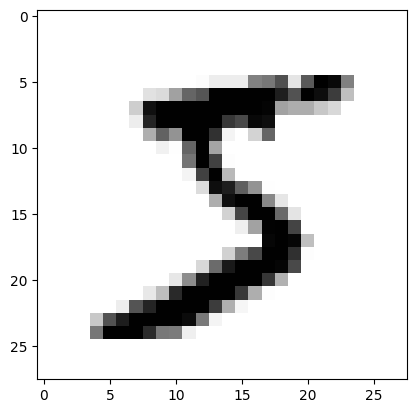

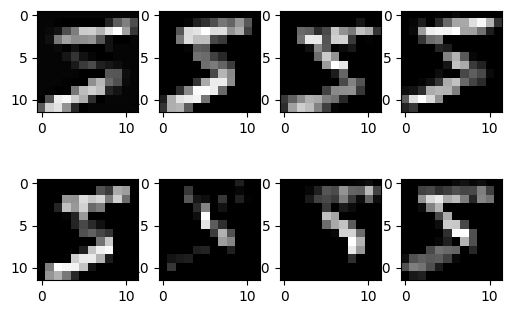

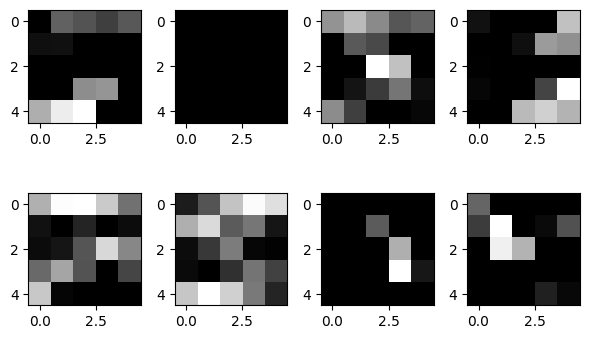

In [60]:
sample_x = train_x[0].reshape((1, 28, 28))

plt.imshow(sample_x[0], cmap='gray_r')
plt.show()

def forward_sequential(x, layers):
    for layer in layers:
        x = layer.forward(x)
    return x

# Первая свёртка
convolved1 = forward_sequential(sample_x, model.nodes[:3])
show_multiple(convolved1, 2, 4)

#Вторая свёртка
convolved2 = forward_sequential(convolved1, model.nodes[3:6])
show_multiple(convolved2, 2, 4)
plt.tight_layout()
